In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [5]:
start_dt = '2021-07-29'
end_dt = '2021-08-17'


Estimate impact of aaid 


In [48]:
df = bigquery_client.query(f"""
select
    platform
    , os_version_text
    , no_ifa
    , date
    , 16*sum(if(event_type = 'clear',1,0)) impressions
    , 16*sum(if(event_type = 'click',1,0)) clicks
    , 16*sum(if(event_type = 'install',1,0)) installs
    , 16*sum(if(event_type = 'clear',settlement_price,0))/1000 cost
    , 16*sum(if(event_type = 'clear',1.25*settlement_price,0))/1000 media_cost
    , 16*sum(if(event_type = 'install',revenue,0)) spend
from stats.rows1 
where
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) = '0'
group by 1,2,3,4
""").to_dataframe()
df['os_major'] = df['os_version_text'].str.split('.').str[0].astype(int, errors = 'ignore')
df

platform os_version_text  no_ifa        date  impressions  clicks  \
0           2.0          13.7.0     0.0  2021-07-01          240       0   
1           2.0          14.2.0     0.0  2021-07-01          832       0   
2           1.0         7.1.1.0     0.0  2021-07-01           64       0   
3           1.0          11.0.0     0.0  2021-07-01       661664   34400   
4           2.0          11.0.1     1.0  2021-07-01           48       0   
...         ...             ...     ...         ...          ...     ...   
22399       2.0          19.0.0     0.0  2021-08-18            0       0   
22400       2.0            13.7     0.0  2021-08-18        18112     656   
22401       2.0          10.3.2     0.0  2021-08-18          224       0   
22402       1.0             8.1     1.0  2021-08-18         3744     112   
22403       1.0           4.0.4     1.0  2021-08-18           16       0   

       installs         cost   media_cost    spend os_major  
0             0     0.011107     0.013884     0.00       13  
1             0     0.122968     0.153711     0.00       14  
2             0     0.076528     0.095660     0.00        7  
3          3808  4199.820858  5249.776073  5225.76       11  
4             0     0.010720     0.013400     0.00       11  
...         ...          ...          ...      ...      ...  
22399         0     0.000000     0.000000     0.00       19  
22400        32    28.016582    35.020728   102.88       13  
22401         0     0.272591     0.340739     0.00       10  
22402         0     1.262626     1.578283     0.00        8  
22403         0     0.001872     0.002340     0.00        4  

[22404 rows x 11 columns]

In [78]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['margin'] = 100*(df['spend']-df['media_cost'])/df['spend']

    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['spend_sov'] = 100*df['spend']/df['spend'].sum()
        df['total_media_cost'] = df['media_cost'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['spend_sov'] = 100*df['spend']/df.groupby(sov_base)['spend'].transform(sum)
        df['total_media_cost'] = df.groupby(sov_base)['media_cost'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','media_cost','media_cost_sov','margin','total_media_cost']]

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'spend':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'rpi':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'bpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'spend_sov':'{:,.0f}%'
             ,'win_rate':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'cost_sov':'{:,.0f}%'
             ,'bid_sov':'{:,.0f}%'
             ,'impression_sov':'{:,.0f}%'
             ,'cost_increase':'{:,.0f}%'
             ,'spend_increase':'{:,.0f}%'}

In [79]:
filters = (df.platform == 1) & (df.date < datetime.date.today())
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','media_cost','spend'], index = 'date', columns = 'no_ifa',aggfunc = np.sum)
pivot.index = pd.to_datetime(pivot.index)
no_ifa_bydate = calc_metrics(pivot[[c for c in pivot.columns if c[1] == 1]].droplevel(axis=1,level=1))
yes_ifa_bydate = calc_metrics(pivot[[c for c in pivot.columns if c[1] == 0]].droplevel(axis=1,level=1))
yes_ifa_bydate.style.format(format_map)


Text(0.5, 1.0, 'has ifa')

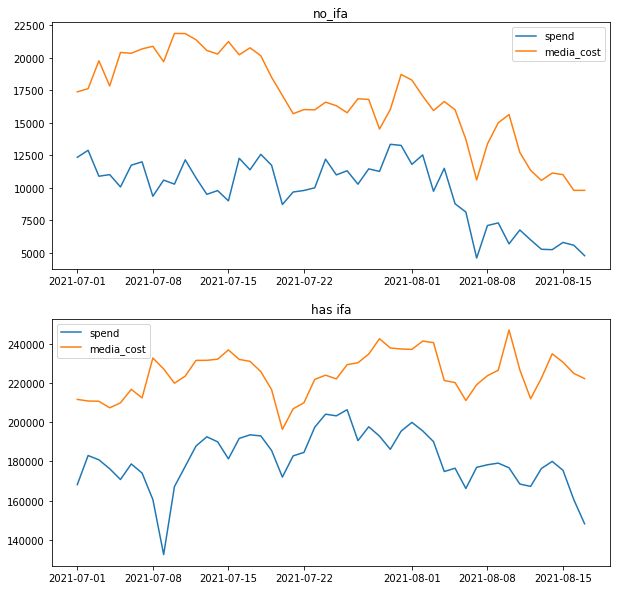

In [75]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(no_ifa_bydate[['spend','media_cost']])
ax[0].legend(['spend','media_cost'])
ax[0].set_title('no_ifa')
ax[1].plot(yes_ifa_bydate[['spend','media_cost']])
ax[1].legend(['spend','media_cost'])
ax[1].set_title('has ifa')

In [68]:
pivot = df[(df.platform == 1) & (df.date >= pd.to_datetime('2021-08-05'))].pivot_table(values = ['impressions','clicks','installs','media_cost','spend'], index = 'os_major', columns = 'no_ifa',aggfunc = np.sum)
pivot.index = pd.to_numeric(pivot.index, errors = 'ignore')
pivot.sort_index(inplace = True)
no_ifa_byosv = calc_metrics(pivot[[c for c in pivot.columns if c[1] == 1]].droplevel(axis=1,level=1))
yes_ifa_byosv = calc_metrics(pivot[[c for c in pivot.columns if c[1] == 0]].droplevel(axis=1,level=1))
no_ifa_byosv[no_ifa_byosv.media_cost > 100]

impressions     clicks       ctr  installs        ir       ipm  \
os_major                                                                   
10         58019152.0  1905488.0  3.284240   16368.0  0.858993  0.282114   
11         52324880.0   870880.0  1.664371    8880.0  1.019658  0.169709   
4           1352544.0    48656.0  3.597369     464.0  0.953634  0.343057   
5           2621120.0   207712.0  7.924551    1200.0  0.577723  0.457820   
6           4018256.0   378608.0  9.422197    2064.0  0.545155  0.513656   
7           5920992.0   316752.0  5.349644    1248.0  0.393999  0.210775   
8          13488976.0   695600.0  5.156804    4576.0  0.657849  0.339240   
9          21969984.0   604176.0  2.750007    3584.0  0.593205  0.163132   

               cpm       rpi     spend  spend_sov    media_cost  \
os_major                                                          
10        1.294322  2.243695  36724.80  43.479908  75095.481168   
11        0.748366  2.625315  23312.80  27.600924  39158.138184   
4         0.676367  0.368966    171.20   0.202690    914.816474   
5         1.240835  1.602267   1922.72   2.276382   3252.378005   
6         1.933962  1.745504   3602.72   4.265399   7771.152730   
7         0.999238  1.750897   2185.12   2.587048   5916.482955   
8         1.406941  1.873531   8573.28  10.150237  18978.194704   
9         0.823452  2.224107   7971.20   9.437411  18091.221373   

          media_cost_sov      margin  total_media_cost  
os_major                                                
10             44.376343 -104.481661     169224.133668  
11             23.139807  -67.968404     169224.133668  
4               0.540595 -434.355417     169224.133668  
5               1.921935  -69.155051     169224.133668  
6               4.592225 -115.702378     169224.133668  
7               3.496241 -170.762382     169224.133668  
8              11.214828 -121.364457     169224.133668  
9              10.690686 -126.957313     169224.133668

In [65]:
df_bids = bigquery_client.query(f"""
select
    if(ssb_buyer_id=3549,'singletap','appreciate') buyer,
    req.device_dnt,
    req.device_lmt,
    count(*) responses,
    sum(if(r.mv_clear=1,1,0)) imps,
    sum(if(r.mv_clicked=1,1,0)) clicks,
    sum(if(r.mv_install=1,1,0)) installs,
    sum(max_revenue) revenue
from `apprec-prod.raw_traffic.responses` res
left join `apprec-prod.raw_traffic.requests` req 
    ON (req.id=res.id) 
    and req.exchange_id = 1
    and req.device_os = 'Android'
    and date(req.t_created) >= '{start_dt}'
left join `apprec-prod.stats.mv_wins_unique_4` r 
    ON (r.id=res.bidid) 
    and r.exchange_id = 1
    and r.date >= '{start_dt}'
where
    date(res.t_created) >= '{start_dt}'
    and res.exchange_id=1
group by 1,2,3 order by 1,2,3
""").to_dataframe()
df_bids

buyer  device_dnt  device_lmt  responses    imps  clicks  installs  \
0  appreciate         NaN         NaN     636616  158530    1181        32   
1  appreciate         0.0         0.0     603663   34532     586        40   
2  appreciate         1.0         1.0      20354    1696      13         0   
3   singletap         NaN         NaN      12243   12240     184         6   
4   singletap         0.0         0.0     165824  165760    4056       224   
5   singletap         1.0         1.0      13730   13728     158         1   

     revenue  
0   41.44425  
1   46.87125  
2    0.00000  
3   16.60000  
4  404.29000  
5    3.60000